# Face Recognition with Siamese Network

In this project, we explore face recognition using a Siamese Neural Network. Siamese Networks are well-suited for this task, as they are designed to learn similarities between pairs of data points, making them ideal for recognizing faces in different scenarios. Throughout this report, we will delve into the process of creating and training a Siamese Network for face recognition.

Let's first take a quick look at what this network is.

A Siamese network include sseveral, typically two or three, backbone neural networks which share weights. Different loss functions have been proposed for training a Siamese network. Two commonly used ones are **triplet loss** and **contrastive loss** which are displayed in image.

<img src='https://www.researchgate.net/profile/Benyamin-Ghojogh/publication/347038642/figure/fig1/AS:969358884995072@1608124576765/Siamese-network-with-a-contrastive-and-b-triplet-loss-functions.png'>

[Source Publication](https://www.researchgate.net/publication/347038642_Fisher_Discriminant_Triplet_and_Contrastive_Losses_for_Training_Siamese_Networks)

#### Which one to choose?
- **Triplet Loss**: Its applications are in face recognition and in-person re-identification.
- **Contrastive Loss**: Its applications are in similarity learning, image retrieval, and in recommendations systems.

#### So triplet loss is the perfect choice for out task!
Let's start!

## Import Libraries

In [35]:
import os
import zipfile

import random
import math
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Flatten, Dense,\
                                    Dropout, BatchNormalization, Input
from tensorflow.keras.metrics import Mean, CosineSimilarity
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input

In [5]:
FACE_DATA_PATH = '/kaggle/input/face-recognition-dataset/Face Data/Face Dataset'
EXTRACTED_FACES_PATH = '/kaggle/input/face-recognition-dataset/Extracted Faces/Extracted Faces'

## Dataset Exploration
### Exploring Folder Contents

In this section, we explore the contents of a specified folder using the `explore_folder` function. The objective is to gain insights into the dataset we are working with. This function takes a `folder_path` as input and performs the following tasks:

- Iterates through subfolders within the specified folder.
- For each subfolder, it reads the images and collects information about their shapes.
- Calculates the total number of images and the total number of unique people in the dataset.
- Displays the unique image shapes and summary statistics.

This exploration step helps us better understand the composition of our dataset, which is crucial for data preprocessing and model development.


In [6]:
def explore_folder(folder_path):
    print(f'Exploring {os.path.basename(folder_path)}')
    image_shapes = []
    num_images = 0
    num_people = 0
    for folder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, folder_name)
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            image = cv2.imread(image_path)
            image_shapes.append(image.shape)
            num_images += 1
        num_people +=1
    print(f'Unique image shapes in: {set(image_shapes)}')
    print(f"Total number of images: {num_images}")
    print(f"Total number of people: {num_people}")
    return image_shapes, num_images, num_people

Let's run the `explore_folder` function to analyze the dataset's characteristics.

In [7]:
explore_folder(FACE_DATA_PATH);

Exploring Face Dataset

Unique image shapes in: {(250, 250, 3)}

Total number of images: 8204

Total number of people: 1680


In [8]:
explore_folder(EXTRACTED_FACES_PATH);

Exploring Extracted Faces

Unique image shapes in: {(128, 128, 3)}

Total number of images: 6107

Total number of people: 1324


The dataset consists of two folders: Face Dataset and Extracted Faces. First one has 8204 (250x250) images of 1680 individuals and second one - 6107 (128, 128) and 1324 respectively. Each image has 3 channels, meaning it is RGB encoded.

Notice the difference in number of images and people in these two folders. We will deal with it later.

### Visualizing Sample Images

In this section, we utilize the `visualize_sample_images` function to display a grid of sample images from a specified folder. The primary goal is to provide a visual representation of the dataset's contents and to illustrate the appearance of individuals in the dataset.

This visualization helps us get a glimpse of the dataset's visual diversity and confirms that the images are loaded correctly.

In [21]:
def visualize_sample_images(folder_path):
    num_images = len(os.listdir(folder_path))
    num_rows = (num_images + 4) // 5
    num_cols = min(num_images, 5)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))

    for i, image_name in enumerate(os.listdir(folder_path)):
        image_path = os.path.join(folder_path, image_name)
        sample_image = cv2.imread(image_path)
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

        row = i // num_cols
        col = i % num_cols

        if num_rows == 1:
              ax = axes[col]
        else:
            ax = axes[row, col]

        ax.imshow(sample_image)
        ax.axis('off')

    for ax in axes.flat[num_images:]:
          ax.remove()

    plt.suptitle(f'Person ID: {os.path.basename(folder_path)}')
    plt.tight_layout()
    plt.show()

Let's use the `visualize_sample_images` function to view sample images from a specific person's folder.

Samples from Face Dataset


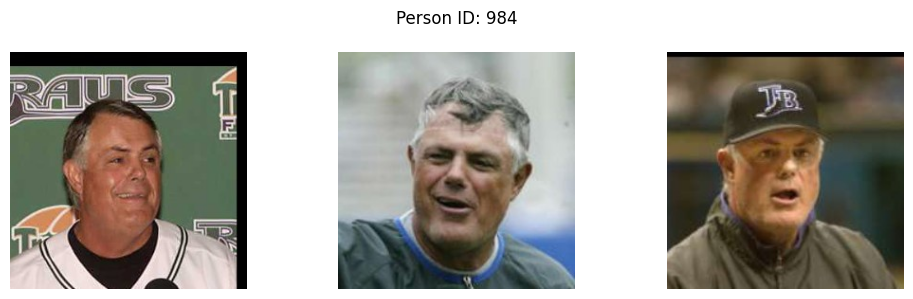

In [22]:
person_id = random.choice(os.listdir(FACE_DATA_PATH))
folder_path = os.path.join(FACE_DATA_PATH, person_id)
print(f'Samples from {os.path.basename(FACE_DATA_PATH)}')
visualize_sample_images(folder_path)

In [23]:
print(f'Samples from {os.path.basename(EXTRACTED_FACES_PATH)}')
if person_id in os.listdir(EXTRACTED_FACES_PATH):
    folder_path = os.path.join(EXTRACTED_FACES_PATH, person_id)  
    visualize_sample_images(folder_path)
else:
    print(f'There is no person {person_id} in this folder')

Samples from Extracted Faces

There is no person 984 in this folder


### Creating a Dataset

To prepare our dataset for further model training, we need to create a consolidated output dataset that combines images from the original face dataset and the extracted faces dataset.

The main goal of this step is to increase size of the data. The more data we have - the better!

In [16]:
DATASET = 'images/output_dataset'
if os.path.exists(DATASET):
    shutil.rmtree(DATASET)    
os.makedirs(DATASET)

def copy_to_output_dataset(input_path, output_path):
    for person_folder in os.listdir(input_path):
        person_folder_path = os.path.join(input_path, person_folder)
        if os.path.isdir(person_folder_path):
            output_person_folder = os.path.join(output_path, person_folder)
            if not os.path.exists(output_person_folder):
                os.makedirs(output_person_folder)

            for image_file in os.listdir(person_folder_path):
                if image_file.endswith('.jpg'):
                    src_image_path = os.path.join(person_folder_path, image_file)
                    dst_image_path = os.path.join(output_person_folder, image_file)
                    if os.path.exists(dst_image_path):
                        base, ext = os.path.splitext(dst_image_path)
                        dst_image_path = f"{base}_1{ext}"
                    shutil.copy(src_image_path, dst_image_path)

copy_to_output_dataset(FACE_DATA_PATH, DATASET)                
copy_to_output_dataset(EXTRACTED_FACES_PATH, DATASET) 

In [17]:
explore_folder(DATASET);

Exploring Output Dataset

Unique image shapes in: {(250, 250, 3), (128, 128, 3)}

Total number of images: 14311

Total number of people: 1680


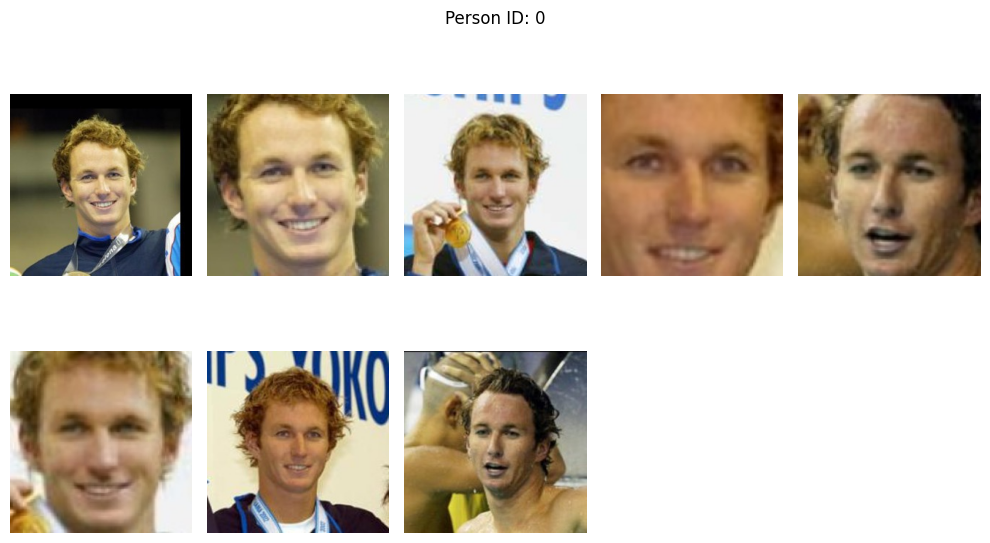

In [25]:
visualize_sample_images(os.path.join(DATASET, '0'))

## Siamese Neural Network
### Generating Triplets
To train a Siamese network for face recognition, we need to create triplets of images for each training batch. Each triplet consists of an **anchor image** (a sample image of a person), a **positive image** (another image of the same person), and a **negative image** (an image of a different person). These triplets are used to calculate the triplet loss, which encourages the network to learn to differentiate between different individuals.

In [26]:
def triplets(folder_paths, max_triplets=7):
    anchor_images = []
    positive_images = []
    negative_images = []

    for person_folder in folder_paths:
        images = [os.path.join(person_folder, img)
                  for img in os.listdir(person_folder)]
        num_images = len(images)

        if num_images < 2:
            continue

        random.shuffle(images)

        for _ in range(max(num_images-1, max_triplets)):
            anchor_image = random.choice(images)

            positive_image = random.choice([x for x in images
                                            if x != anchor_image])

            negative_folder = random.choice([x for x in folder_paths
                                             if x != person_folder])

            negative_image = random.choice([os.path.join(negative_folder, img)
                                            for img in os.listdir(negative_folder)])

            anchor_images.append(anchor_image)
            positive_images.append(positive_image)
            negative_images.append(negative_image)

    return anchor_images, positive_images, negative_images

This code generates triplets by randomly selecting anchor, positive, and negative images, ensuring that the negative image comes from a different person's folder. The number of triplets per person is capped at `max_triplets` to control the training dataset size.

In [28]:
person_folders = [os.path.join(DATASET, folder_name)
                  for folder_name in os.listdir(DATASET)]

anchors, positives, negatives = triplets(person_folders)

### Splitting Triplets

To train a Siamese network effectively, it's essential to have both a training and a validation set of triplets. The training set is used to optimize the model's parameters, while the validation set helps monitor the model's performance and prevent overfitting.

In [29]:
def split_triplets(anchors,
                   positives,
                   negatives,
                   validation_split=0.2):

    triplets = list(zip(anchors, positives, negatives))

    train_triplets, val_triplets = train_test_split(triplets,
                                                    test_size=validation_split,
                                                    random_state=42)

    return train_triplets, val_triplets

In [30]:
train_triplets, val_triplets = split_triplets(anchors,
                                              positives,
                                              negatives)
len(train_triplets), len(val_triplets)

(13854, 3464)

### Loading and Preprocessing Images

Before using images in a machine learning model, it's essential to preprocess them consistently. This preprocessing typically involves tasks like resizing, color space conversion, and optional dimension expansion.

In [31]:
def load_and_preprocess_image(image_path, expand_dims=False):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    if expand_dims:
        image = np.expand_dims(image, axis=0)
    return image

### Batch Generator with Data Augmentation

Data augmentation is a common technique used to increase the diversity of training data by applying random transformations to input images. This can help improve the robustness and generalization of machine learning models. In this code block, we define a batch generator for Siamese networks with an option to apply data augmentation.

The generator employs the following data augmentation techniques:
- Random rotation (up to 10 degrees)
- Random horizontal and vertical shifts (up to 5% of the image size)
- Horizontal flipping
- Random zooming (up to 20%)

The `batch_generator` function takes a list of triplets, a batch size, and an augment flag as input. It shuffles the indices of triplets, applies data augmentation to the anchor, positive, and negative images (if `augment` is True), and yields batches of augmented triplets for training the Siamese network.

In [58]:
def batch_generator(triplets, batch_size=32, augment=True):
    total_triplets = len(triplets)
    random_indices = list(range(total_triplets))
    random.shuffle(random_indices)
    
    datagen = ImageDataGenerator(
        rotation_range=10,  
        width_shift_range=0.05, 
        height_shift_range=0.05,   
        horizontal_flip=True,
        zoom_range=0.2
    )
    
    for i in range(0, total_triplets, batch_size):
        batch_indices = random_indices[i:i + batch_size]
        batch_triplets = [triplets[j] for j in batch_indices]

        anchor_batch = []
        positive_batch = []
        negative_batch = []

        for triplet in batch_triplets:
            anchor, positive, negative = triplet
            
            anchor_image = load_and_preprocess_image(anchor)
            positive_image = load_and_preprocess_image(positive)
            negative_image = load_and_preprocess_image(negative)
                
            if augment:
                anchor_image = datagen.random_transform(anchor_image)
                positive_image = datagen.random_transform(positive_image)
                negative_image = datagen.random_transform(negative_image)

            anchor_batch.append(anchor_image)
            positive_batch.append(positive_image)
            negative_batch.append(negative_image)

        yield [np.array(anchor_batch),
               np.array(positive_batch),
               np.array(negative_batch)]

### Visualizing Triplets
The `visualize_triplets` function takes a batch of triplets as input and displays the anchor, positive, and negative images side by side in a single row. Visualizing triplets can help us to verify that the data is loaded and preprocessed correctly and gain insights into the face recognition process.

In [59]:
def visualize_triplets(triplets):
    anchor_batch, positive_batch, negative_batch = triplets

    for i in range(len(anchor_batch)):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title("Anchor")
        plt.imshow(anchor_batch[i])
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Positive")
        plt.imshow(positive_batch[i])
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Negative")
        plt.imshow(negative_batch[i])
        plt.axis('off')

        plt.show()

Let's visualize a random batch.

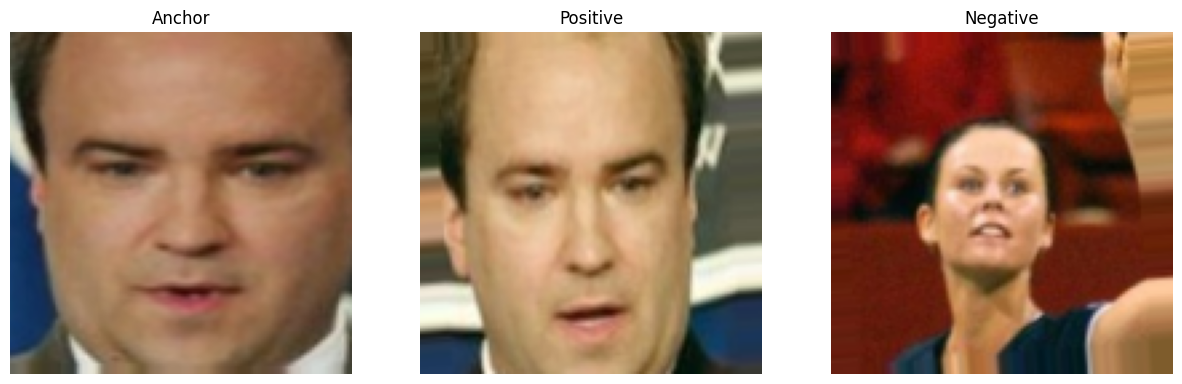

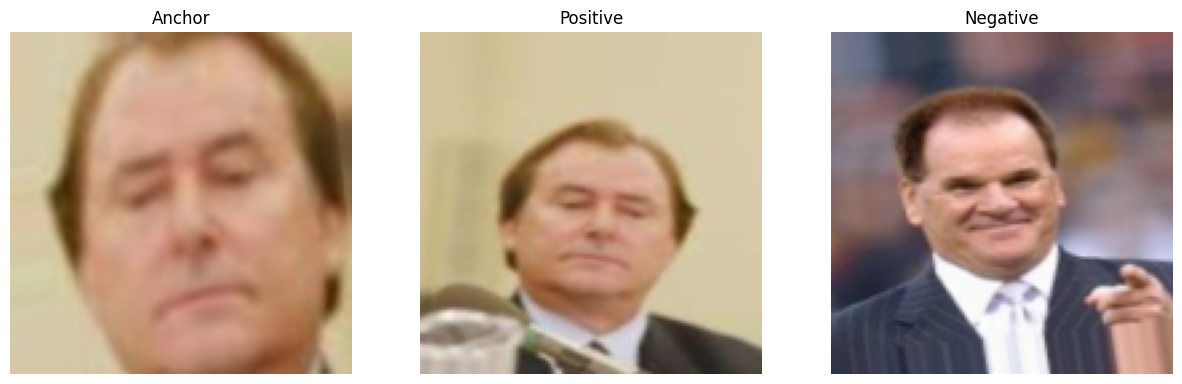

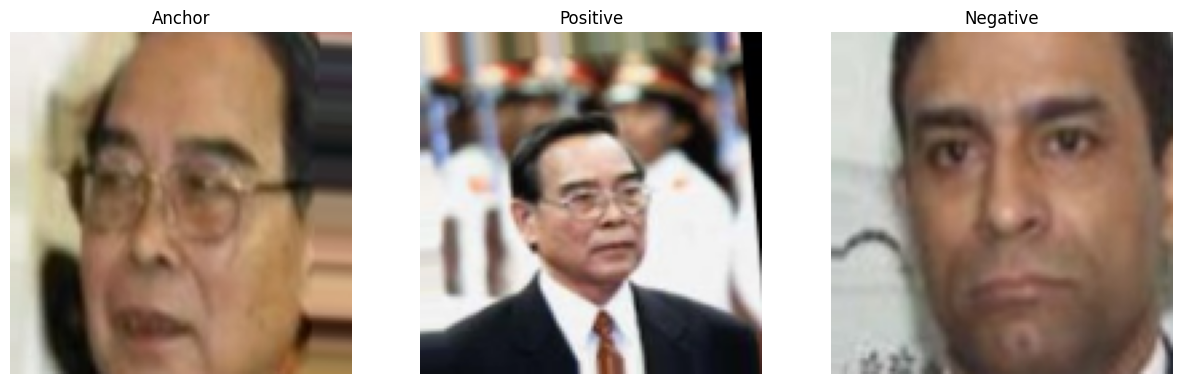

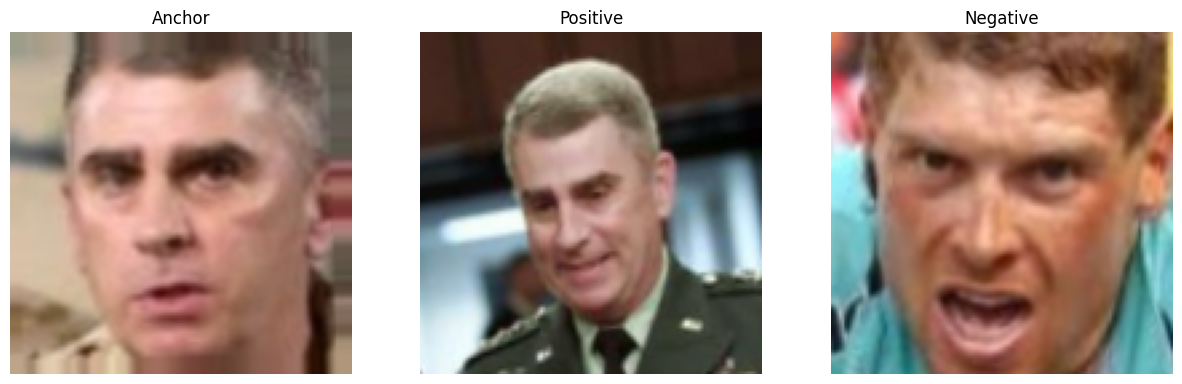

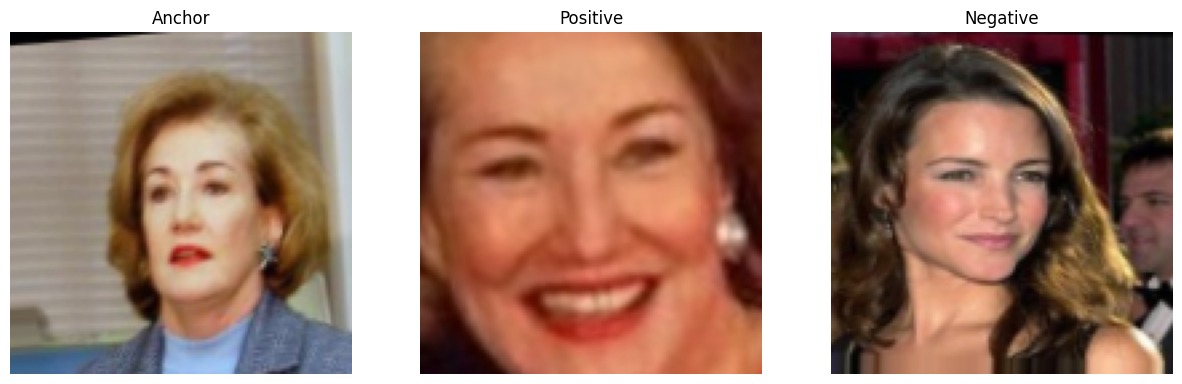

In [61]:
example_triplets = [next(batch_generator(train_triplets, 5))]
visualize_triplets(example_triplets[0])

### Defining the Embedding Model

The `get_embedding` function serves the purpose of creating the embedding model that extracts meaningful representations (embeddings) from input images. In this context, the embedding model plays a crucial role in face recognition, as it transforms images into a feature space where similar faces are close together and dissimilar faces are farther apart.

This function utilizes the **EfficientNetB7** architecture, a powerful convolutional neural network pretrained on ImageNet, as the base model. It then adds additional layers to fine-tune the model for the face recognition task. 

In [70]:
def get_embedding(input_shape, num_layers_to_unfreeze=25):
    base_model = EfficientNetB7(weights='imagenet',
                                input_shape=input_shape,
                                include_top=False,
                                pooling='avg')

    for i in range(len(base_model.layers)-num_layers_to_unfreeze):
        base_model.layers[i].trainable = False

    embedding = tf.keras.models.Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(128)
    ], name='Embedding')

    return embedding

In [71]:
input_shape = (128, 128, 3)

embedding = get_embedding(input_shape)
embedding.summary()

Model: "Embedding"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 efficientnetb7 (Functional)  (None, 2560)             64097687  

                                                                 

 flatten_1 (Flatten)         (None, 2560)              0         

                                                                 

 dense_3 (Dense)             (None, 512)               1311232   

                                                                 

 batch_normalization_2 (Batc  (None, 512)              2048      

 hNormalization)                                                 

                                                                 

 dropout_2 (Dropout)         (None, 512)               0         

                                                                 

 dense_4 (Dense)             (None, 256)               131328    

                                         

### Siamese Network Architecture

In this code block, we define the architecture of a Siamese Network. The goal is to minimize the distance between anchor and positive embeddings while maximizing the distance between anchor and negative embeddings.

Here's a breakdown of the key components:

1. **DistanceLayer**: This custom Keras layer computes the Euclidean distances between the anchor and positive embeddings (ap_distance) and between the anchor and negative embeddings (an_distance). These distances will be used to calculate the triplet loss during training.

$$d_{AP} = \sum_{i=1}^{N} (a_i - p_i)^2, d_{AN} = \sum_{i=1}^{N} (a_i - n_i)^2$$

where $a_i$, $p_i$, and $n_i$ are the elements of the anchor, positive, and negative embeddings, respectively.


2. **Inputs**: Three input tensors (`anchor_input`, `positive_input`, and `negative_input`) are defined, representing the anchor, positive, and negative images, respectively. The `shape` of these inputs corresponds to the desired input image shape (128x128x3).

3. **Embedding Model**: The `embedding` model is applied to each input image to obtain their embeddings. 

4. **Distance Computation**: The `DistanceLayer` layer computes the distances between the embeddings obtained from the anchor, positive, and negative images.

5. **Siamese Network**: Finally, the Siamese network is defined as a Keras model that takes the three input images and outputs the computed distances. This network serves as the core component for training and evaluating the triplet loss.

In [72]:
@tf.keras.saving.register_keras_serializable()
class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance

anchor_input = Input(name='anchor', shape=input_shape)
positive_input = Input(name='positive', shape=input_shape)
negative_input = Input(name='negative', shape=input_shape)

distances = DistanceLayer()(
    embedding(preprocess_input(anchor_input)),
    embedding(preprocess_input(positive_input)),
    embedding(preprocess_input(negative_input))
)

siamese_net = Model(
    inputs=[anchor_input,
            positive_input,
            negative_input],
    outputs=distances
)

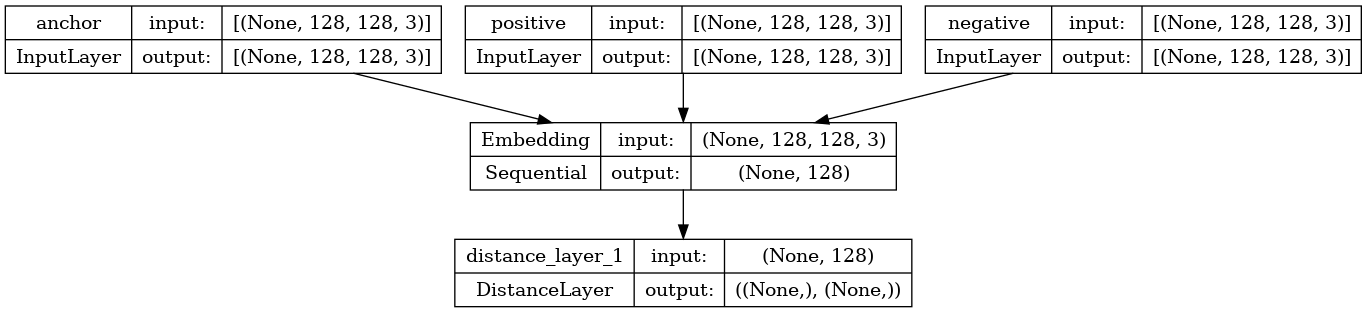

In [73]:
plot_model(siamese_net, show_shapes=True, show_layer_names=True)

In [74]:
siamese_net.summary()

Model: "model_1"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 anchor (InputLayer)            [(None, 128, 128, 3  0           []                               

                                )]                                                                

                                                                                                  

 positive (InputLayer)          [(None, 128, 128, 3  0           []                               

                                )]                                                                

                                                                                                  

 negative (InputLayer)          [(None, 128, 128, 3  0           []                               

                                )]                                               

### Custom Siamese Model

In this code block, we define a custom Keras model called `SiameseModel` designed for training and evaluating Siamese Networks. The Siamese Model wraps the Siamese network defined earlier and includes custom training and evaluation logic for the face recognition task.

Here's a breakdown of the key components and functionalities:

1. **Initialization**: The `SiameseModel` class is initialized with the Siamese network (`siamese_net`) and a margin value (`margin`) for the triplet loss function. It also creates trackers for loss and accuracy metrics.

2. **`call` Method**: The `call` method defines the forward pass of the Siamese Model. It takes a batch of triplets as input and passes it through the Siamese network, returning the computed distances between anchor-positive and anchor-negative pairs.

3. **Custom Training Logic (`train_step`)**: The `train_step` method is called during training. It computes the triplet loss using the distances obtained from the Siamese network. It then computes gradients and applies them to update the Siamese network's trainable weights. Additionally, it updates the loss and accuracy trackers.

4. **Custom Evaluation Logic (`test_step`)**: The `test_step` method is called during evaluation. It computes the triplet loss and accuracy in a similar way to the training step but without backpropagation.

5. **Loss Calculation (`_compute_loss`)**: This private method calculates the triplet loss based on the anchor-positive and anchor-negative distances. The loss is defined as the difference between these distances, subject to a margin, ensuring that similar pairs have smaller distances.

6. **Accuracy Calculation (`_compute_accuracy`)**: This private method computes the accuracy by comparing the anchor-positive and anchor-negative distances. It counts how often the anchor-positive distance is smaller than the anchor-negative distance.

7. **Metrics Property**: The `metrics` property returns a list of loss and accuracy metrics for tracking during training and evaluation.

8. **Serialization Methods**: The `get_config` and `from_config` methods are provided for model serialization. They enable saving and loading the Siamese Model's configuration, including its custom objects ([reference](https://www.tensorflow.org/guide/keras/serialization_and_saving))

This code block is a crucial part of the project, as it defines the model that learns to recognize faces based on learned embeddings and the triplet loss function.

In [75]:
@tf.keras.saving.register_keras_serializable()
class SiameseModel(Model):
    def __init__(self, siamese_net, margin=0.5):
        super().__init__()
        self.siamese_net = siamese_net
        self.margin = margin
        self.loss_tracker = Mean(name='loss')
        self.accuracy_tracker = Mean(name='accuracy')

    def call(self, inputs):
        return self.siamese_net(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_net.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_net.trainable_weights)
        )

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_net(data)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, .0)
        return loss

    def _compute_accuracy(self, data):
        ap_distance, an_distance = self.siamese_net(data)
        accuracy = tf.reduce_mean(tf.cast(ap_distance < an_distance,
                                          tf.float32))
        return accuracy

    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

    def get_config(self):
        base_config = super().get_config()
        config = {
            'siamese_net': tf.keras.saving.serialize_keras_object(self.siamese_net),
            'margin': tf.keras.saving.serialize_keras_object(self.margin),
            'loss_tracker': tf.keras.saving.serialize_keras_object(self.loss_tracker),
            'accuracy_tracker': tf.keras.saving.serialize_keras_object(self.accuracy_tracker),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        config['siamese_net'] = tf.keras.saving.deserialize_keras_object(config.pop('siamese_net'))
        config['margin'] = tf.keras.saving.deserialize_keras_object(config.pop('margin'))
        config['loss_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('loss_tracker'))
        config['accuracy_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('accuracy_tracker'))
        return cls(**config)

### Training the Siamese Model

The next code block defines a function `train_model` for training a Siamese model on face recognition using triplet loss. 

1. **Function Parameters**: The function takes several parameters, including the Siamese model (`model`), training triplets (`train_triplets`), the number of training epochs (`epochs`), batch size (`batch_size`), validation triplets (`val_triplets`), and early stopping parameters (`patience` and `delta`).

2. **Training Loop**: The code implements a training loop that runs for the specified number of epochs. During each epoch, it trains the Siamese model using training triplets and evaluates it on validation triplets.

3. **Progress Bar**: The code uses the `tqdm` library to create progress bars for training and validation. This provides a visual indication of the training progress and the current loss and accuracy.

4. **Batch Training**: The training data is divided into batches using the `batch_generator` function. The model is updated with each batch using the `train_on_batch` method.

5. **Loss and Accuracy Tracking**: The code tracks training and validation loss as well as accuracy for each epoch and stores them in a `history` dictionary.

6. **Model Checkpoint**: The best model weights are saved when the validation accuracy improves. 

7. **Early Stopping**: Early stopping prevents overfitting by stopping training if the validation loss does not improve significantly (`delta`) for a specified number of epochs (`patience`).

8. **Return Values**: The function returns the trained model and a history dictionary containing loss and accuracy values for each epoch.

In [76]:
def train_model(model,
                train_triplets,
                epochs,
                batch_size,
                val_triplets,
                patience,
                delta=0.0001):

    best_val_accuracy = 0
    best_val_loss = float('inf')
    temp_patience = patience
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    train_steps_per_epoch = math.ceil(len(train_triplets) / batch_size)
    val_steps_per_epoch = math.ceil(len(val_triplets) / batch_size)

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        train_loss = 0.
        train_accuracy = 0.
        val_loss = 0.
        val_accuracy = 0.

        with tqdm(total=train_steps_per_epoch, desc='Training') as pbar:
            for batch in batch_generator(train_triplets, batch_size=batch_size):
                loss, accuracy = model.train_on_batch(batch)
                train_loss += loss
                train_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        with tqdm(total=val_steps_per_epoch, desc='Validation') as pbar:
            for batch in batch_generator(val_triplets, batch_size=batch_size):
                loss, accuracy = model.test_on_batch(batch)
                val_loss += loss
                val_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        train_loss /= train_steps_per_epoch
        train_accuracy /= train_steps_per_epoch
        val_loss /= val_steps_per_epoch
        val_accuracy /= val_steps_per_epoch

        history['loss'].append(train_loss)
        history['accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            model.layers[0].layers[3].save_weights('best_model.weights.h5')

        if val_loss - best_val_loss > delta:
            temp_patience -= 1
            if temp_patience == 0:
                print('Early stopping: Validation loss did not improve.')
                break
        else:
            best_val_loss = val_loss
            temp_patience = patience

    return model, history

#### Finally, let's train the model!

In [77]:
siamese_model = SiameseModel(siamese_net)
siamese_model.compile(optimizer=Adam(0.001))

siamese_model, history = train_model(siamese_model,
                                     train_triplets=train_triplets,
                                     epochs=200,
                                     batch_size=128,
                                     val_triplets=val_triplets,
                                     patience=3)

Epoch 1/200


Training: 100%|██████████| 109/109 [10:22<00:00,  5.71s/it, Loss=0.199, Accuracy=0.833]

Validation: 100%|██████████| 28/28 [02:58<00:00,  6.37s/it, Loss=0.122, Accuracy=1]    




Train Loss: 0.2232, Train Accuracy: 0.8841

Validation Loss: 0.1793, Validation Accuracy: 0.8580



Epoch 2/200


Training: 100%|██████████| 109/109 [07:47<00:00,  4.29s/it, Loss=0.13, Accuracy=0.9]   

Validation: 100%|██████████| 28/28 [01:51<00:00,  3.99s/it, Loss=0.159, Accuracy=0.875]




Train Loss: 0.1658, Train Accuracy: 0.9076

Validation Loss: 0.2016, Validation Accuracy: 0.8474



Epoch 3/200


Training: 100%|██████████| 109/109 [07:51<00:00,  4.33s/it, Loss=0.143, Accuracy=0.9]   

Validation: 100%|██████████| 28/28 [01:51<00:00,  3.99s/it, Loss=0.126, Accuracy=0.875]




Train Loss: 0.1433, Train Accuracy: 0.9173

Validation Loss: 0.1616, Validation Accuracy: 0.8744



Epoch 4/200


Training: 100%|██████████| 109/109 [07:58<00:00,  4.39s/it, Loss=0.0863, Accuracy=0.967]

Validation: 100%|██████████| 28/28 [01:53<00:00,  4.06s/it, Loss=0.0611, Accuracy=1]   




Train Loss: 0.1288, Train Accuracy: 0.9253

Validation Loss: 0.1467, Validation Accuracy: 0.8786



Epoch 5/200


Training: 100%|██████████| 109/109 [07:58<00:00,  4.39s/it, Loss=0.227, Accuracy=0.833] 

Validation: 100%|██████████| 28/28 [01:51<00:00,  3.99s/it, Loss=0.138, Accuracy=0.875] 




Train Loss: 0.1211, Train Accuracy: 0.9321

Validation Loss: 0.1385, Validation Accuracy: 0.8917



Epoch 6/200


Training: 100%|██████████| 109/109 [07:50<00:00,  4.31s/it, Loss=0.203, Accuracy=0.9]   

Validation: 100%|██████████| 28/28 [01:51<00:00,  3.99s/it, Loss=0.289, Accuracy=0.75]  




Train Loss: 0.1051, Train Accuracy: 0.9427

Validation Loss: 0.1619, Validation Accuracy: 0.8697



Epoch 7/200


Training: 100%|██████████| 109/109 [07:58<00:00,  4.39s/it, Loss=0.0997, Accuracy=0.9]  

Validation: 100%|██████████| 28/28 [01:51<00:00,  3.96s/it, Loss=0, Accuracy=1]        




Train Loss: 0.0949, Train Accuracy: 0.9491

Validation Loss: 0.1453, Validation Accuracy: 0.8878



Epoch 8/200


Training: 100%|██████████| 109/109 [07:51<00:00,  4.32s/it, Loss=0.0916, Accuracy=0.933]

Validation: 100%|██████████| 28/28 [01:54<00:00,  4.09s/it, Loss=0.109, Accuracy=0.875] 



Train Loss: 0.0955, Train Accuracy: 0.9526

Validation Loss: 0.1449, Validation Accuracy: 0.8890



Early stopping: Validation loss did not improve.


## Model Evaluation
### Training Visualization

After the training is complete, let's create a visual representation of the model's training progress.

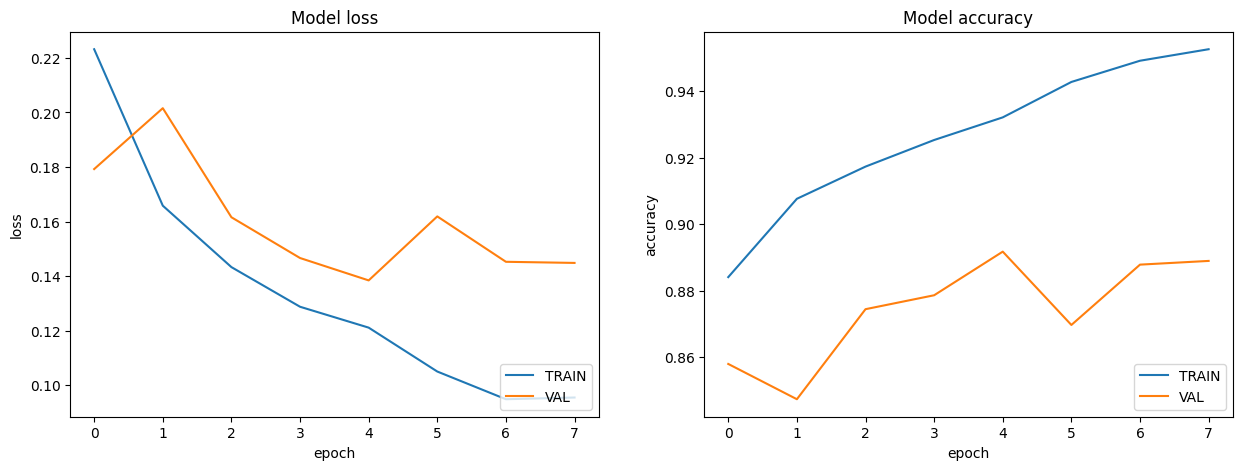

In [78]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')

plt.subplot(122)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')

plt.show()

We can observe how the loss decreases and accuracy increases over training epochs. The comparison between training and validation curves helps identify potential overfitting or underfitting issues. In an ideal scenario, both loss curves should decrease, and accuracy curves should increase over time, but we can see that validation metrics don't show so much improvement, meaning that the model generalizations are not perfect.

### Calculating Cosine Similarity

These similarity scores can help evaluate the effectiveness of the Siamese model. A higher positive similarity indicates that the anchor and positive samples are more similar, which is expected. Conversely, a lower negative similarity indicates that the anchor and negative samples are less similar, which is also expected.

Let's compute and compare cosine similarity between embeddings of anchor, positive, and negative samples. 

In [79]:
sample = next(batch_generator(val_triplets, 1))

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(preprocess_input(anchor)),
    embedding(preprocess_input(positive)),
    embedding(preprocess_input(negative))
)

cosine_similarity = CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print(f'Positive similarity: {positive_similarity}')

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print(f'Negative similarity: {negative_similarity}')

Positive similarity: 0.9970422983169556

Negative similarity: 0.8683284521102905


The positive similarity score is close to 1.0, which indicates a very high similarity between the anchor image and the positive image in the pair.
The negative similarity score is also quite high but slightly lower than the positive similarity score. This score indicates that the anchor and negative images in the pair are somewhat similar but still dissimilar.  In the context of a Siamese network for tasks like face recognition, this suggests that while the anchor and negative images might share some features, they are still distinguishable from each other.